In [2]:
!pip install git+https://github.com/raghakot/keras-vis.git -U

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-tg21r8ok
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-tg21r8ok
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38887 sha256=093ad21637654f33f39dfb7c12db78780fa5e5d4bab628c4cd654b5246abafd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-plu4iw1c/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [0]:
from keras.preprocessing import image
from keras import backend as K
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=True, 
              weights='imagenet', 
              input_tensor=None, 
              input_shape=None)





553467904/553467096 [==============================] - 12s 0us/step








In [5]:
model.summary() 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [32]:
img_path = 'cat.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# 正規化
img_tensor /= 255.

# 形状を表示
print(img_tensor.shape)

(1, 224, 224, 3)


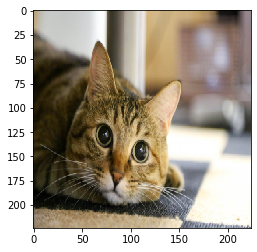

In [33]:
plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

# 上位16層の出力を抽出
layer_outputs = [layer.output for layer in model.layers[2:16]]

# モデル入力を指定すると、これらの出力を返すモデルを作成する。
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
# 5つのNumpy配列（層の活性化ごとに１つ）のリストを返す
activations = activation_model.predict(img_tensor)

In [31]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 64)


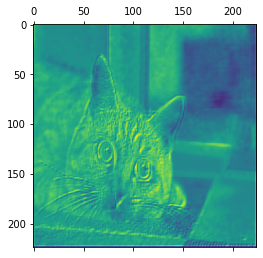

In [57]:
# 1つ目の層の3番目のチャネルを表示
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

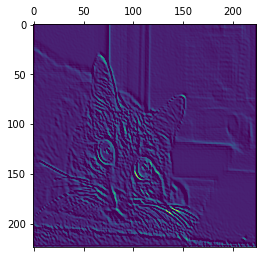

In [44]:
# 1つ目の層の30番目のチャネルを表示
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [109]:
fourth_layer_activation = activations[3]
print(fourth_layer_activation.shape)

(1, 112, 112, 128)


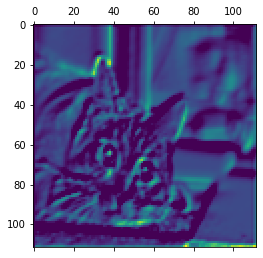

In [110]:
# 4つ目の層の3番目のチャネルを表示
plt.matshow(fourth_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

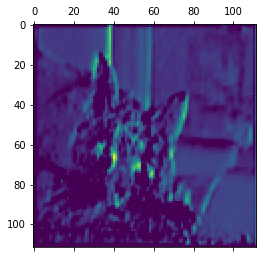

In [111]:
# 4つ目の層の3番目のチャネルを表示
plt.matshow(fourth_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [63]:
import keras

# プロットの一部として使用する層の名前
layer_names = []
for layer in model.layers[2:16]:
    layer_names.append(layer.name)

images_per_row = 16

# 特徴マップを表示
for layer_name, layer_activation in zip(layer_names, activations):
    # 特徴マップに含まれている特徴量の数
    n_features = layer_activation.shape[-1]

    # 特徴マップの形状 (1, size, size, n_features)
    size = layer_activation.shape[1]

    # この行列で活性化のチャネルをタイル表示
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 各フィルタを１つの大きな水平グリッドでタイル表示
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 特徴量の見た目をよくするための後処理
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # グリッド表示
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
layer_name = 'block5_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
grads = K.gradients(loss, model.input)[0]

In [0]:
# 除算の前に 1e-5 を足すことで、0による除算を回避
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
# 最初は、ノイズが含まれたグレースケール画像を使用
input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.

# 勾配法を40ステップ実行
step = 1.  # 各勾配の更新の大きさ
for i in range(40):
    # 損失値と勾配値を計算
    loss_value, grads_value = iterate([input_img_data])
    # 勾配が最大になる方向に入力画像を調整
    input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
    # テンソルを正規化：中心を0、標準偏差を0.1にする
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1] でクリッピングする
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 配列 に変換
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:

def generate_pattern(layer_name, filter_index, size=224):
    # ターゲット層のn番目のフィルタの活性化を最大化する損失関数を構築
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # この損失関数を使って入力画像の勾配を計算
    grads = K.gradients(loss, model.input)[0]

    # 勾配を正規化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 入力画像に基づいて損失値と勾配値を返す関数
    iterate = K.function([model.input], [loss, grads])
    
    # 最初はノイズが含まれたグレースケール画像を使用
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 勾配法を40ステップ実行
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

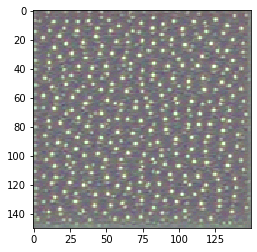

In [69]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


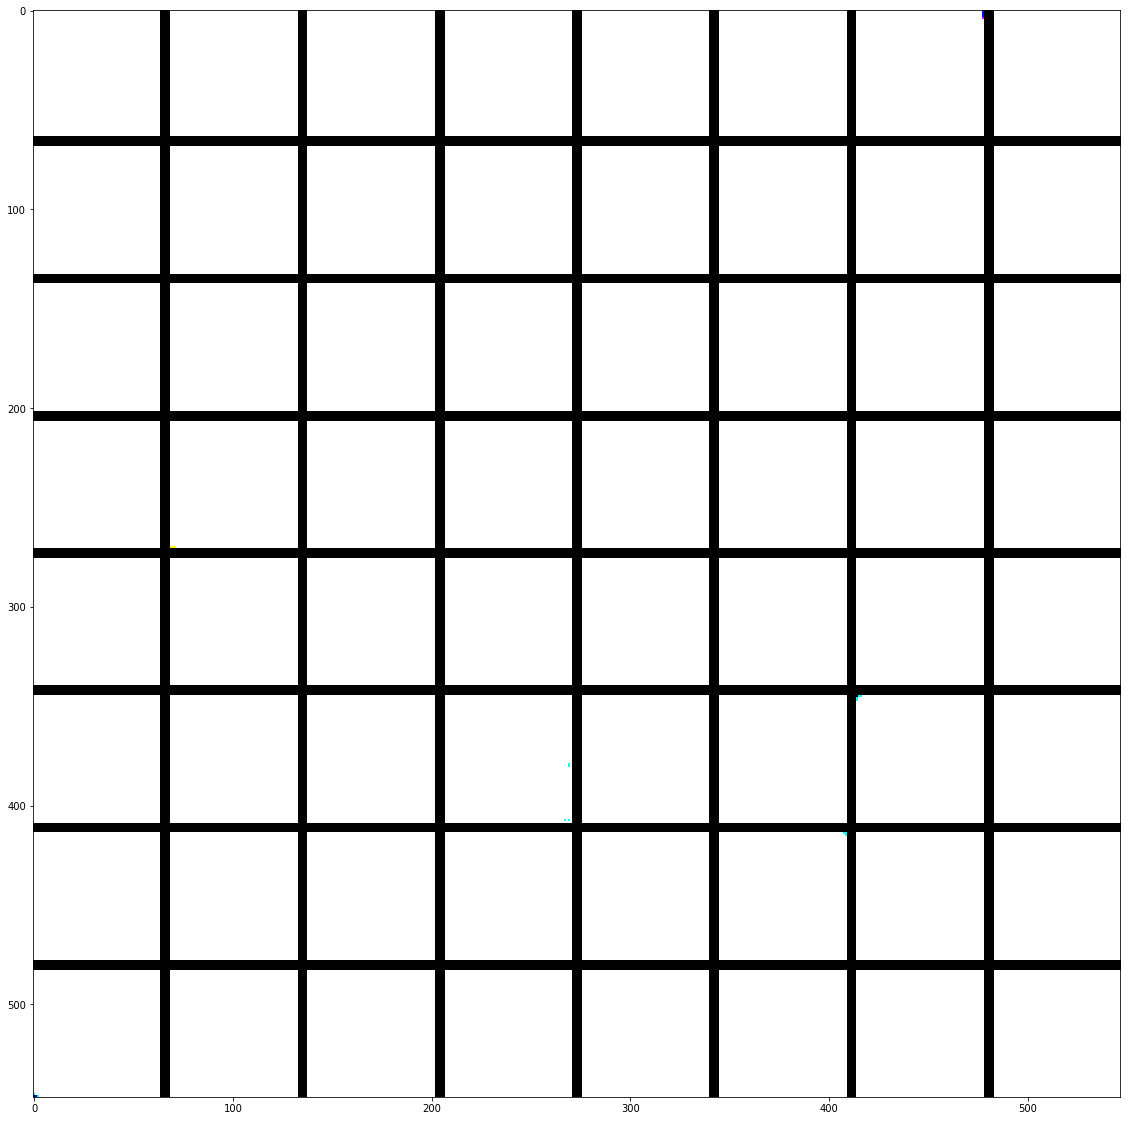

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


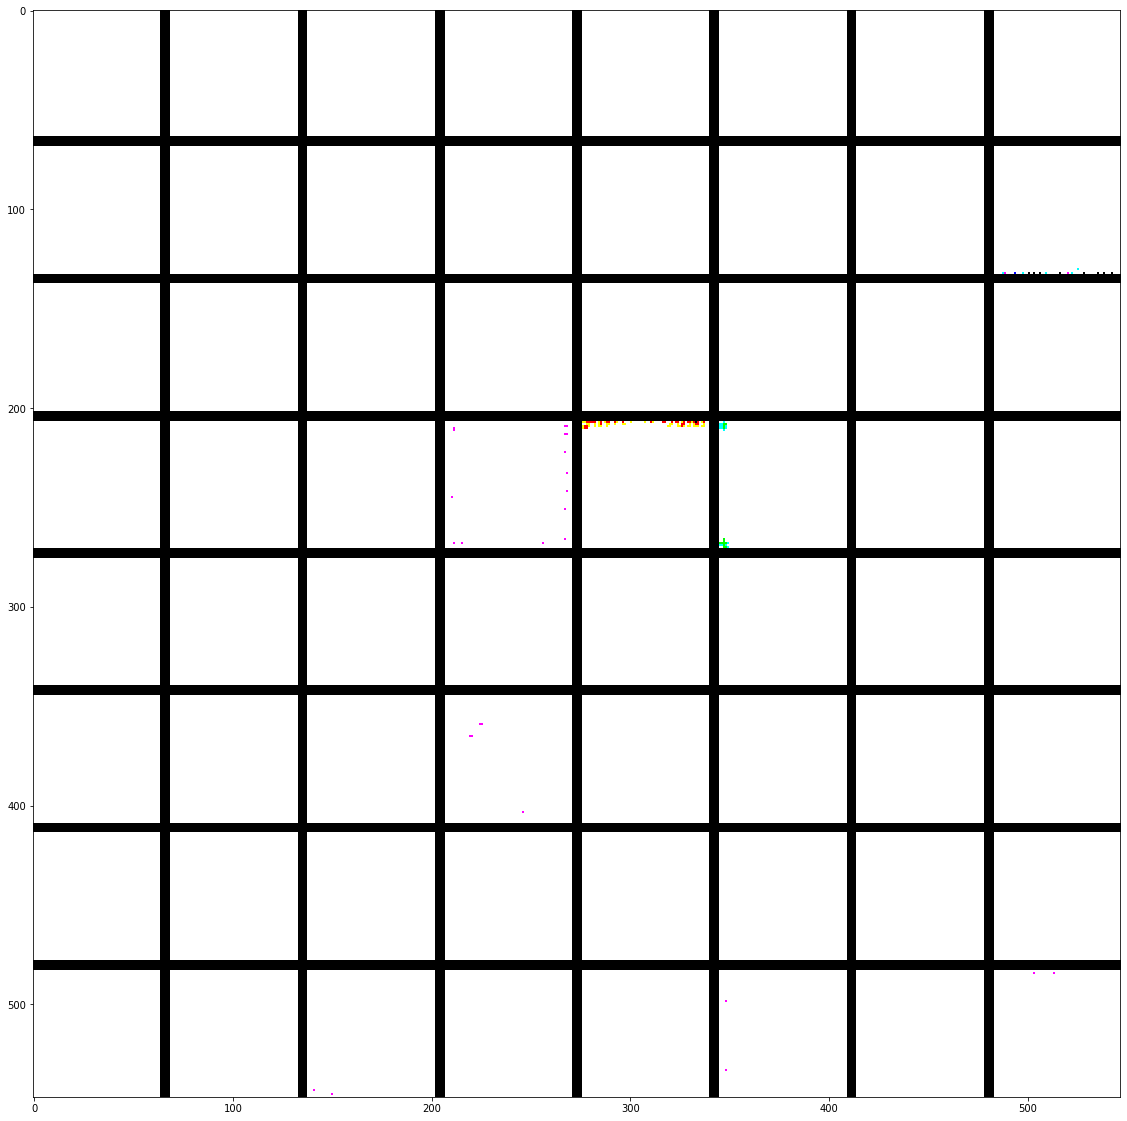

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


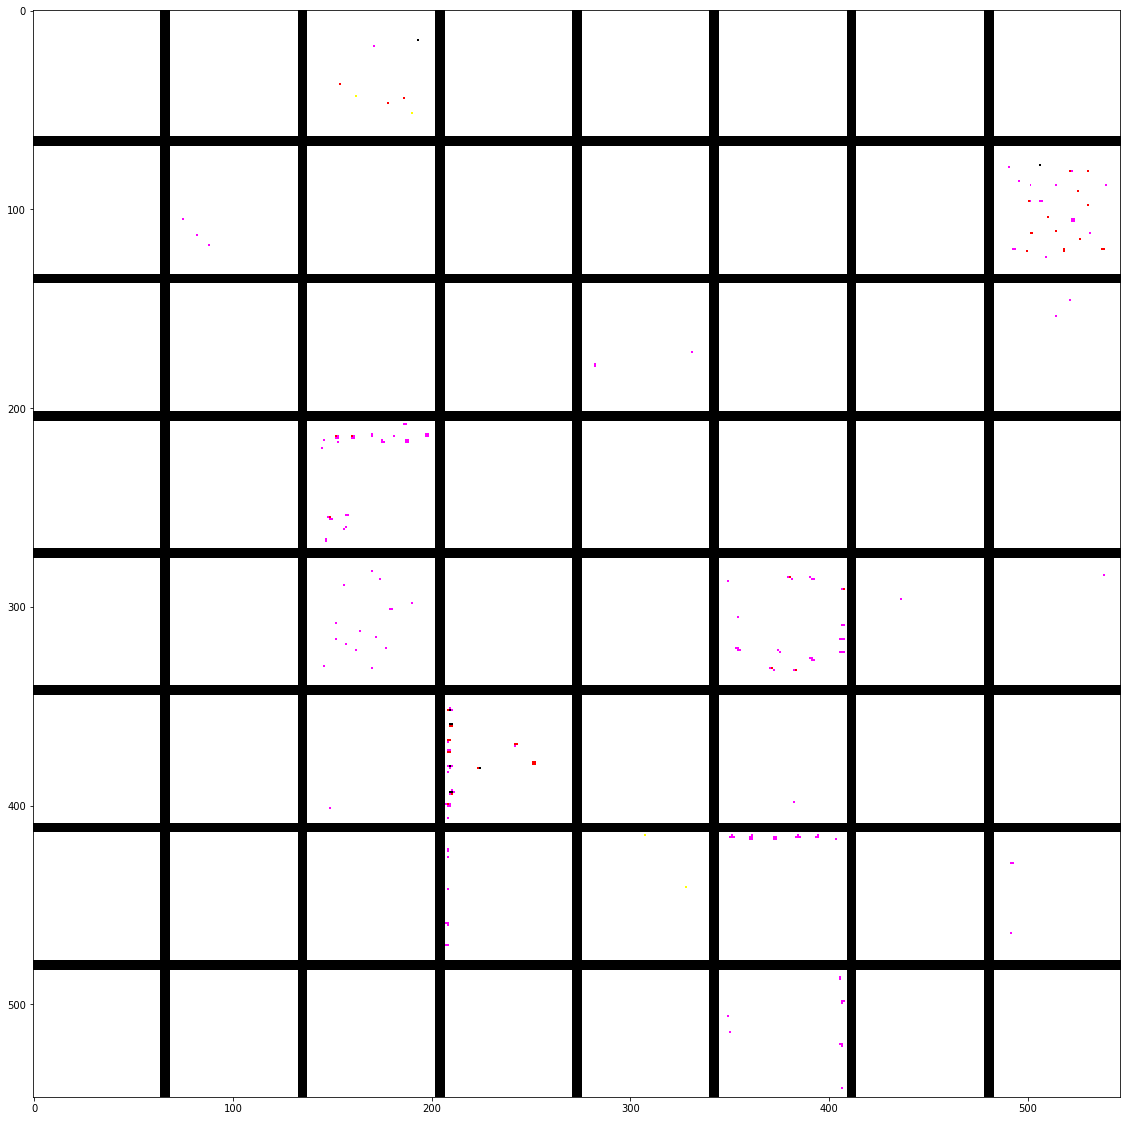

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


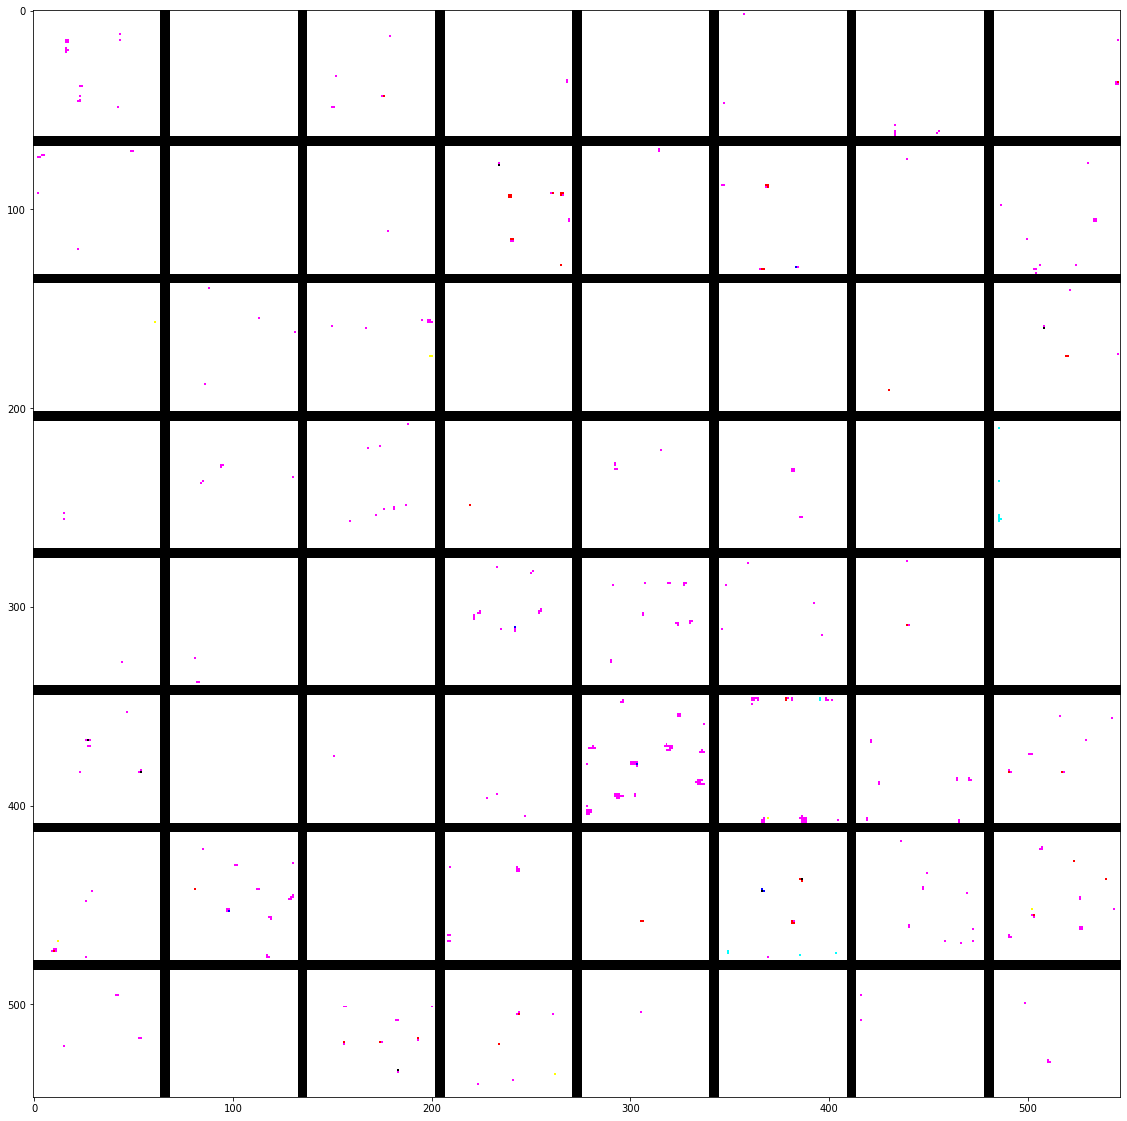

In [70]:

for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 結果を格納する空（黒）の画像
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # resultsグリッドの行を順番に処理
        for j in range(8):  # resultsグリッドの列を順番に処理
            # layer_name のフィルタ i + (j * 8) のパターンを生成
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # resultsグリッドの矩形(i, j) に結果を配置
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # resultsグリッドを表示
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

# CAM

In [0]:
K.clear_session()
model = VGG16(weights='imagenet')

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [117]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02124075', 'Egyptian_cat', 0.46586436), ('n02123045', 'tabby', 0.29810882), ('n02123159', 'tiger_cat', 0.16138795)]


In [118]:
np.argmax(preds[0])

285

In [0]:
# 最大の予測ベクトルを取得
model_output = model.output[:, 285]

# VGG16の最後の畳み込み層であるblock5_conv3の出力特徴
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3の出力特徴マップでの勾配
grads = K.gradients(model_output, last_conv_layer.output)[0]

# 各エントリは特定の特徴マップチャネルの勾配の平均強度
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# pooled_grads と block5_conv3の出力特徴マップの値にアクセスするための関数
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# これらの2つの値をNumpy配列として取得
pooled_grads_value, conv_layer_output_value = iterate([x])

# 「チャネルの重要度」を特徴マップ配列の各チャネルに掛ける
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 最終的な特徴マップのチャネルごとの平均値がクラスの活性化のヒートマップ
heatmap = np.mean(conv_layer_output_value, axis=-1)

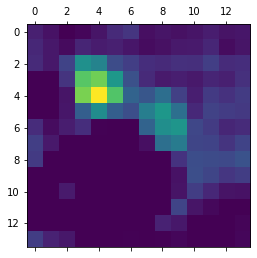

In [124]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [125]:
import cv2

# CV2を使って元の画像を読み込む
img = cv2.imread(img_path)

# 元の画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)

# ヒートマップを元の画像に適用
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 は、ヒートマップの強度係数
superimposed_img = heatmap * 0.4 + img

# 保存
cv2.imwrite('/content/cat_heatmap.jpg', superimposed_img)

True